## XCEPTION NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.13.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 2000 images belonging to 10 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2000 images belonging to 10 classes.


In [5]:
def xception(input_shape, n_classes):
  
  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 128, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 256, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])
    
    return x
  
  
  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])
    
    return tensor
  
  
  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 1024, 1, 2)
    
    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)
  
    return x
  
  
  input = Input(input_shape)
  
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 10

K.clear_session()
model = xception(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 32)         0         ['batch_normalization[0][0

 re_lu_6 (ReLU)              (None, 28, 28, 728)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 separable_conv2d_5 (Separa  (None, 28, 28, 728)          536536    ['re_lu_6[0][0]']             
 bleConv2D)                                                                                       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 728)          186368    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 batch_normalization_9 (Bat  (None, 28, 28, 728)          2912      ['separable_conv2d_5[0][0]']  
 chNormali

                                                                                                  
 separable_conv2d_12 (Separ  (None, 14, 14, 728)          536536    ['re_lu_13[0][0]']            
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_17 (Ba  (None, 14, 14, 728)          2912      ['separable_conv2d_12[0][0]'] 
 tchNormalization)                                                                                
                                                                                                  
 re_lu_14 (ReLU)             (None, 14, 14, 728)          0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 separable

 tchNormalization)                                                                                
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['add_6[0][0]',               
                                                                     'batch_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 re_lu_22 (ReLU)             (None, 14, 14, 728)          0         ['add_7[0][0]']               
                                                                                                  
 separable_conv2d_21 (Separ  (None, 14, 14, 728)          536536    ['re_lu_22[0][0]']            
 ableConv2D)                                                                                      
          

 re_lu_30 (ReLU)             (None, 14, 14, 728)          0         ['batch_normalization_33[0][0]
                                                                    ']                            
                                                                                                  
 separable_conv2d_29 (Separ  (None, 14, 14, 728)          536536    ['re_lu_30[0][0]']            
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_34 (Ba  (None, 14, 14, 728)          2912      ['separable_conv2d_29[0][0]'] 
 tchNormalization)                                                                                
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['add_9[0][0]',               
          

In [6]:
model_path = "XCEPTION.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 50
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 2.1743 - accuracy: 0.1875 - precision: 0.4615   
Epoch 1: accuracy improved from -inf to 0.18750, saving model to XCEPTION.h5
3/3 [==============================] - 36s 10s/step - loss: 2.1743 - accuracy: 0.1875 - precision: 0.4615 - val_loss: 2.3022 - val_accuracy: 0.1458 - val_precision: 0.0000e+00
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 1.5289 - accuracy: 0.4875 - precision: 0.6341
Epoch 2: accuracy improved from 0.18750 to 0.48750, saving model to XCEPTION.h5
3/3 [==============================] - 23s 8s/step - loss: 1.5289 - accuracy: 0.4875 - precision: 0.6341 - val_loss: 2.3056 - val_accuracy: 0.0729 - val_precision: 0.0000e+00
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.4896 - precision: 0.5397
Epoch 3: accuracy improved from 0.48750 to 0.48958, saving model to XCEPTION.h5
3/3 [==============================] - 27s 10s/step - loss: 1.8795 - accu

3/3 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8854 - precision: 0.8901
Epoch 24: accuracy did not improve from 0.91667
3/3 [==============================] - 27s 10s/step - loss: 0.3599 - accuracy: 0.8854 - precision: 0.8901 - val_loss: 2.3166 - val_accuracy: 0.0938 - val_precision: 0.0000e+00
Epoch 25/50
3/3 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.8542 - precision: 0.8764
Epoch 25: accuracy did not improve from 0.91667
3/3 [==============================] - 27s 10s/step - loss: 0.4339 - accuracy: 0.8542 - precision: 0.8764 - val_loss: 2.3003 - val_accuracy: 0.1250 - val_precision: 0.0000e+00
Epoch 26/50
3/3 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8229 - precision: 0.8667
Epoch 26: accuracy did not improve from 0.91667
3/3 [==============================] - 27s 10s/step - loss: 0.4790 - accuracy: 0.8229 - precision: 0.8667 - val_loss: 2.3033 - val_accuracy: 0.1042 - val_precision: 0.0000e+00
E

3/3 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.9167 - precision: 0.9239
Epoch 48: accuracy did not improve from 0.92708
3/3 [==============================] - 27s 10s/step - loss: 0.3560 - accuracy: 0.9167 - precision: 0.9239 - val_loss: 2.3749 - val_accuracy: 0.0833 - val_precision: 0.0000e+00
Epoch 49/50
3/3 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9062 - precision: 0.9053
Epoch 49: accuracy did not improve from 0.92708
3/3 [==============================] - 27s 10s/step - loss: 0.2373 - accuracy: 0.9062 - precision: 0.9053 - val_loss: 2.3046 - val_accuracy: 0.1250 - val_precision: 0.0000e+00
Epoch 50/50
3/3 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.8542 - precision: 0.8526
Epoch 50: accuracy did not improve from 0.92708
3/3 [==============================] - 27s 10s/step - loss: 0.5705 - accuracy: 0.8542 - precision: 0.8526 - val_loss: 2.3194 - val_accuracy: 0.1250 - val_precision: 0.0000e+00


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

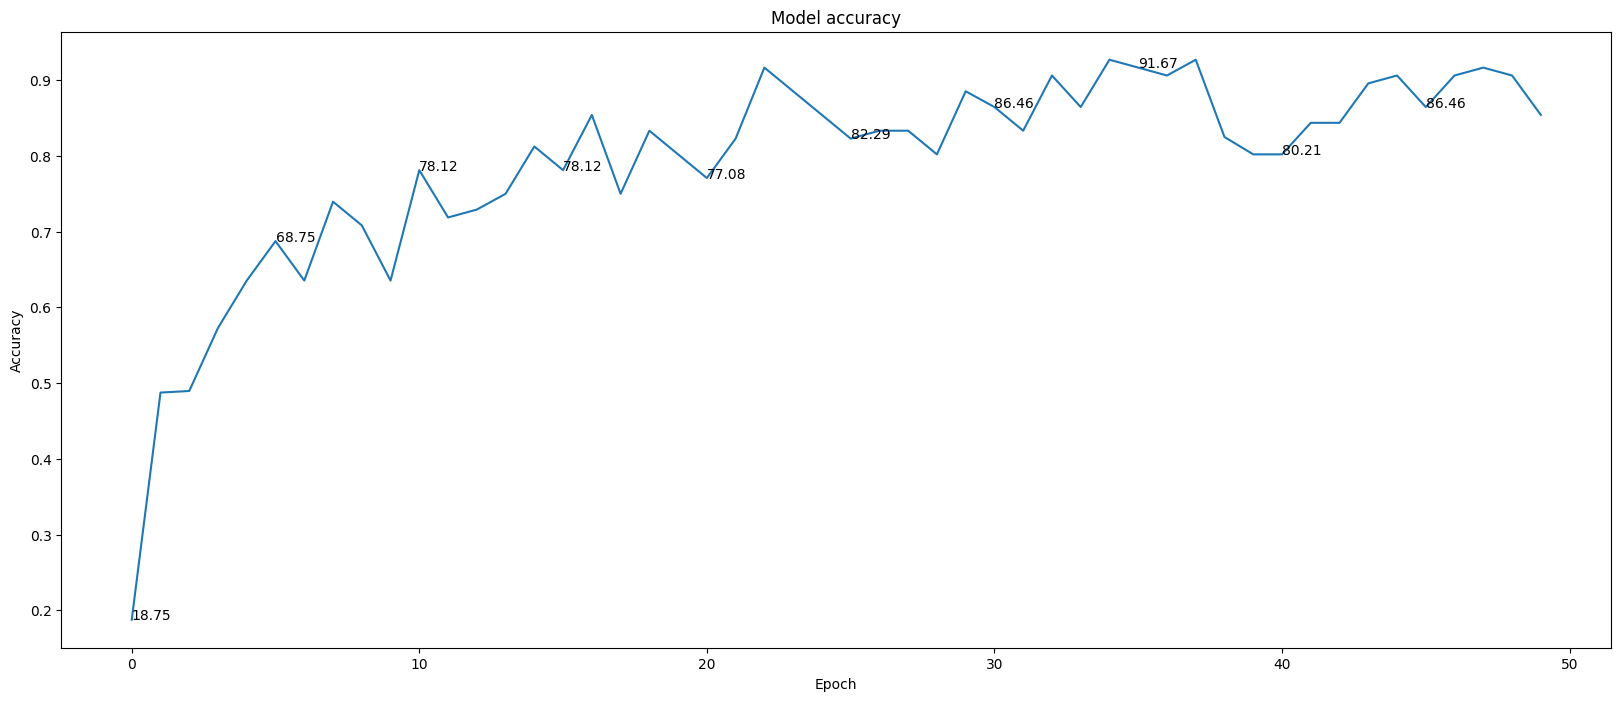

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

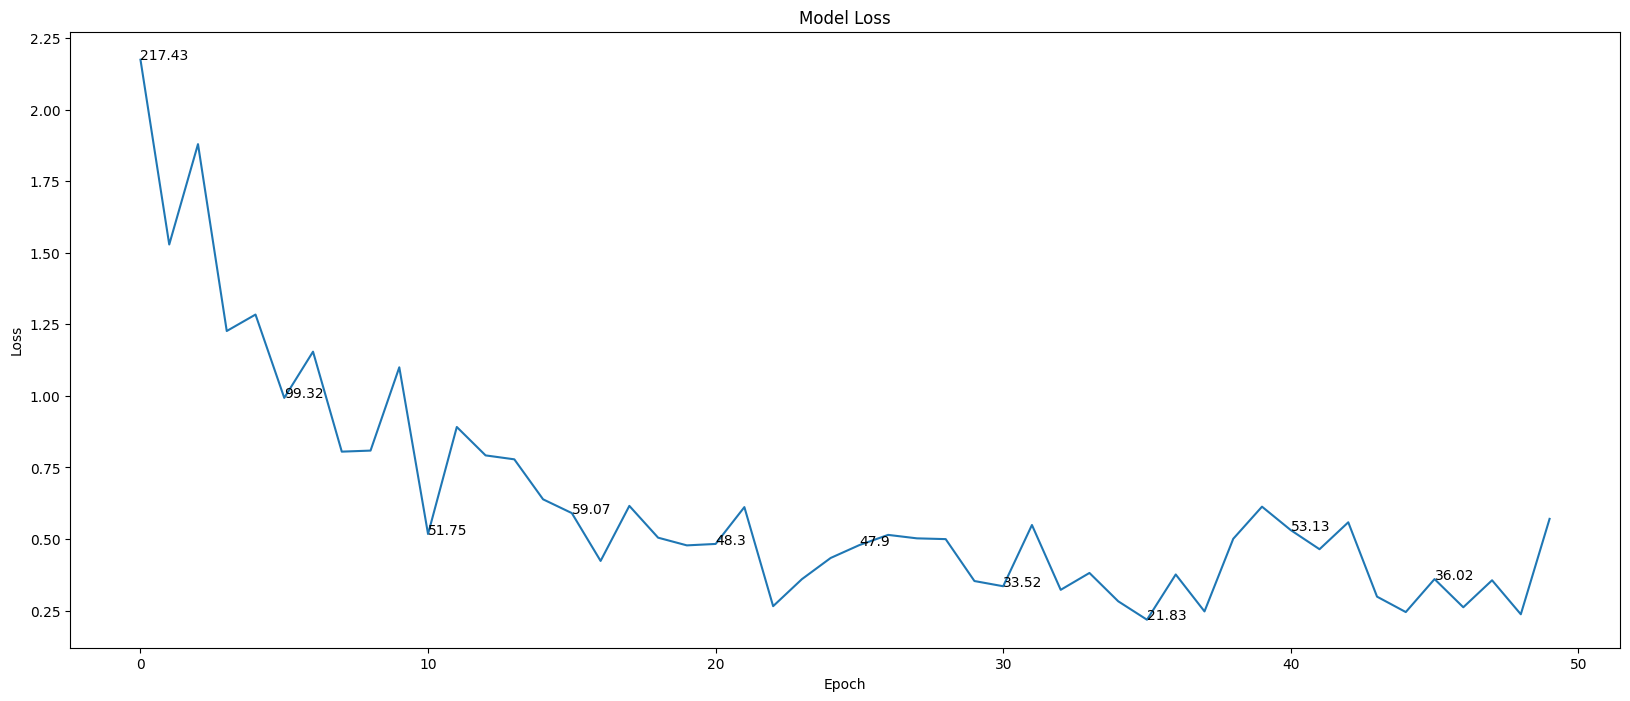

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()